In [7]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

## Bayesian estimation of enzyme elasticities for an in vitro pathway

This notebook is focused on re-creating results from one of the initial papers on linlog kinetics [1]. In this study, data from a simple *in vitro* pathway is used to determine the enzyme elasticity matrix. The model contains 2 internal metabolites and 2 externally controlled metabolite concentrations.

In the original study [2], the authors measure concentrations of the internal metabolites and determine total steady-state flux for 19 different conditions (which vary enzyme loading, $\hat{e}$, and external concentrations $y$). 

In the previous linlog estimation, the authors use multiple linear regression to maximize the $R^2$ value of
$$ \hat{v} = \hat{e} (1 + e_x * \chi + e_y * \gamma) $$
by varying the elasticity matrices $e_x$ and $e_y$ for *measured* values of the fluxes, $v$, and internal and external metabolite concentrations ($\chi$ and $\gamma$, respectively). However, this method doesn't gaurentee you that for a chosen elasticity matrix, your steady state fluxes and concentrations are as close as possible to the measured values. Instead they are fit on a reaction-by-reaction basis.This is probably not a huge issue for smaller models such as this one, but will certainly be a source of error in larger models. Also, it prevents you from fitting any distributions when certain experimental measurements are missing.


1.	L. Wu, W. Wang, W. A. van Winden, W. M. van Gulik, J. J. Heijnen, *European Journal of Biochemistry*. 271, 3348–3359 (2004).
2.	C. Giersch, *European Journal of Biochemistry*. 227, 194–201 (1995).

In [8]:
import numpy as np
np.random.seed(0)

import pandas as pd
import scipy

import pymc as pm
import pytensor
import pytensor.tensor as T
floatX = pytensor.config.floatX

%matplotlib inline

In [9]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

Here we construct the model using the `cobrapy` package, to get the stochiometric matrix from the list of reactions

In [55]:
import cobra

# Initialize model
model = cobra.Model()

# Declare model compartments
model.compartments = {'c': 'the cytosol', 'e': 'extracellular'}

# Define list of metabolites in model per compartment
model.add_metabolites([
        # cobra.Metabolite('bpg_e', compartment='e'),
        cobra.Metabolite('2pg_e', compartment='e'),
        cobra.Metabolite('2pg_c', compartment='c'),
        cobra.Metabolite('pep_e', compartment='e'),
        cobra.Metabolite('pep_c', compartment='c'),
        # cobra.Metabolite('adp_e', compartment='e'),
        cobra.Metabolite('adp_c', compartment='c'),
        ])

# Define model reactions, including exchange reactions to move metabs out of the system
model.add_reactions([
        cobra.Reaction('EX_2pg_e'),
        cobra.Reaction('SK_adp_c'),
        cobra.Reaction('PGM'),
        cobra.Reaction('ENO'),
        cobra.Reaction('PK'),
        cobra.Reaction('EX_pep_e'),
    ])

# Define reaction equations
model.reactions.EX_2pg_e.reaction = '<=> 2pg_e'
model.reactions.SK_adp_c.reaction = '<=> adp_c'
model.reactions.PGM.reaction = '2pg_e <=> 2pg_c'
# model.reactions.PGM.reaction = '<=> 2pg_c'
model.reactions.ENO.reaction = '2pg_c <=> pep_c'
model.reactions.PK.reaction = 'pep_c + adp_c <=> pep_e'
model.reactions.EX_pep_e.reaction = 'pep_e <=>'

# Add objective coefficients
model.objective = "EX_pep_e"

# Save model to file
model_fname = "../tests/test_models/wu2004_model.sbml"
cobra.io.write_sbml_model(model, model_fname)
model_fname = "../tests/test_models/wu2004_model.json"
cobra.io.save_json_model(model, model_fname)


In [41]:
# Define stoichiometric matrix
N = cobra.util.create_stoichiometric_matrix(model, dtype='int')
N

array([[ 1,  0, -1,  0,  0,  0],
       [ 0,  0,  1, -1,  0,  0],
       [ 0,  0,  0,  0,  1, -1],
       [ 0,  0,  0,  1, -1,  0],
       [ 0,  1,  0,  0, -1,  0]])

In [67]:
# For prior predictive purposes ONLY, calculate v_star directly from the model
v_star_prior = model.optimize().fluxes
v_star_prior

EX_2pg_e    1000.0
SK_adp_c    1000.0
PGM         1000.0
ENO         1000.0
PK          1000.0
EX_pep_e    1000.0
Name: fluxes, dtype: float64

In [83]:
# For prior predictive purposes ONLY, calculate LinLog model using only model attributes
import emll
Ex = emll.create_elasticity_matrix(model)
display(Ex)

Ey = np.zeros((6, 2))
Ey[0, 0] = 1  # 2pg_e (+) EX_2pg_e
Ey[5, 1] = 1  # pep_e (+) EX_pep_e
display(Ey)

ll = emll.LinLogLeastNorm(N, Ex, Ey, v_star_prior)

array([[-1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 1., -1.,  0.,  0.,  0.],
       [ 0.,  1.,  0., -1.,  0.],
       [ 0.,  0., -1.,  1.,  1.],
       [ 0.,  0.,  1.,  0.,  0.]])

array([[1., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 1.]])

Load experimental data from a CSV file

In [84]:
giersch = pd.read_csv('data/giersch.csv').astype(float)
n_exp = len(giersch)
giersch.head()

,PGM,ENO,PK,2PG,PEP,BPG,ADP,Flux
0,31.0,5.6,46.0,170.0,50.0,13.2,107.0,157.0
1,25.0,12.0,30.0,60.0,103.0,13.2,61.0,87.0
2,25.0,12.0,30.0,57.0,91.0,13.2,83.0,114.0
3,25.0,12.0,30.0,55.0,83.0,13.2,107.0,128.0
4,25.0,12.0,30.0,54.0,76.0,13.2,130.0,136.0


Here we chop up the experimental data into the e, y, v, and x vectors; and normalize them to the reference state (we use the one with the highest R2 in the original fit [2])

In [85]:
# Load Giersch data directly into relevant variables
e = giersch.loc[:, ['PGM', 'ENO', 'PK']]
y = giersch.loc[:, ['BPG', 'ADP']]
v = giersch.loc[:, ['Flux']]
x = giersch.loc[:, ['2PG', 'PEP']]

# Accomodate cobra model reactions (exchange/sink) missing from Giersch data
# e['EX_2pg_e'] = giersch.loc[:, ['PGM']]
# e['SK_adp_c'] = 0.5*giersch.loc[:, ['PK']]
# e['EX_pep_e'] = giersch.loc[:, ['PK']]

ref_ind = 1

v_star = v.iloc[ref_ind].values * np.ones(3)
x_star = x.iloc[ref_ind].values
y_star = y.iloc[ref_ind].values
e_star = e.iloc[ref_ind].values

# Normalize to reference values (and drop trivial measurement)
en = e.values / e_star
yn = np.log(y.values / y_star)
xn = np.log(x.values / x_star)
vn = v.values / v_star[0]

In [86]:
v_star

array([87., 87., 87.])

In [87]:
n_exp

19

Here we initialize the `LinLogModel` object, which holds some convienience routines. We just use default values for the elasticity matricies.

import emll
Ex = emll.create_elasticity_matrix(model)
display(Ex)

# Ey = np.zeros((3, 2))
# Ey[0, 0] = 1  # bpg (+) PGM
# Ey[2, 1] = 1  # adp (+) PK
Ey = np.zeros((6, 2))
Ey[0, 0] = 1  # 2pg_e (+) EX_2pg_e
Ey[5, 1] = 1  # pep_e (+) EX_pep_e

display(Ey)

ll = emll.LinLogLeastNorm(N, Ex, Ey, v_star)

In [88]:
Ey

array([[1., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 1.]])

## Specify the full probability model

This is the real meat of the inference problem, where we specify the full probability model for our elasticity matricies and observed steady-state responses.

In [89]:
N.shape

(5, 6)

Text(0, 0.5, 'Probability density')

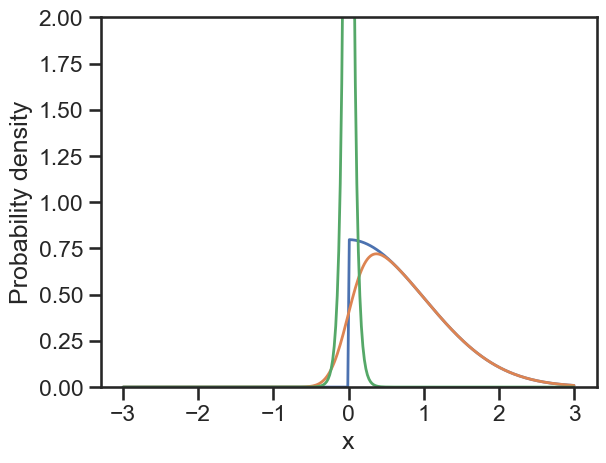

In [90]:
normal_dist = pm.HalfNormal.dist(sigma=1)
t_dist = pm.SkewNormal.dist(mu=0, sigma=1, alpha=5)
s_dist = pm.Laplace.dist(mu=0, b=0.05)

x_eval = np.linspace(-3, 3, 300)
plt.plot(x_eval, T.exp(pm.logp(normal_dist,x_eval)).eval(), lw=2.)
plt.plot(x_eval, T.exp(pm.logp(t_dist, x_eval)).eval(), lw=2.)
plt.plot(x_eval, T.exp(pm.logp(s_dist,x_eval)).eval(), lw=2.)

plt.ylim([0, 2])

plt.xlabel('x')
plt.ylabel('Probability density')

Here's the actual sampling code. First we add our prior distributions on the elasticity matrices and sample the prior predictive distribution. We use the convienence function 'initialize_elasticity' to create the relevant matrix.

In [91]:
from emll.util import initialize_elasticity

print(initialize_elasticity.__doc__)

Initialize the elasticity matrix, adjusting priors to account for
    reaction stoichiometry. Uses `SkewNormal(mu=0, sd=sd, alpha=sign*alpha)`
    for reactions in which a metabolite participates, and a `Laplace(mu=0,
    b=b)` for off-target regulation.

    Also accepts compartments for metabolites and reactions. If given,
    metabolites are only given regulatory priors if they come from the same
    compartment as the reaction.

    Parameters

    N : np.ndarray
        A (nm x nr) stoichiometric matrix for the given reactions and metabolites
    name : string
        A name to be used for the returned pymc3 probabilities
    b : float
        Hyperprior to use for the Laplace distributions on regulatory interactions
    alpha : float
        Hyperprior to use for the SkewNormal distributions. As alpha ->
        infinity, these priors begin to resemble half-normal distributions.
    sigma : float
        Scale parameter for the SkewNormal distribution.
    m_compartments : list
 

In [92]:
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', initialize_elasticity(N, 'ex', b=0.05, sigma=1, alpha=5))
    Ey_t = pm.Deterministic('Ey', initialize_elasticity(-Ey.T, 'ey', b=0.05, sigma=1, alpha=5))
    
with pymc_model:
    trace_prior = pm.sample_prior_predictive()

Sampling: [ex_capacity_entries, ex_kinetic_entries, ey_capacity_entries, ey_kinetic_entries]


In [93]:
trace_prior

Inference data with groups:
	> prior

In [94]:
with pymc_model:
        
    # Error priors. 
    v_err = pm.HalfNormal('v_error', sigma=0.05, initval=.1)
    x_err = pm.HalfNormal('x_error', sigma=0.05, initval=.1)

    # Calculate steady-state concentrations and fluxes from elasticities
    chi_ss, v_hat_ss = ll.steady_state_pytensor(Ex_t, Ey_t, en, yn)

    # Error distributions for observed steady-state concentrations and fluxes
    chi_obs = pm.Normal('chi_obs', mu=chi_ss, sigma=x_err, observed=xn)
    v_hat_obs = pm.Normal('v_hat_obs', mu=v_hat_ss[:, 0].squeeze(),
                          sigma=v_err, observed=vn.squeeze())

#print(pymc_model.logpt.tag.test_value)

ValueError: Incompatible Elemwise input shapes [(19, 3, 1), (1, 6, 6)]

This is the actual computationally intensive portion, where we sample the posterior distribution using hamiltonian monte carlo.

In [16]:
with pymc_model:
    trace = pm.sample(500, random_seed=123, tune=1000,step=pm.NUTS(), n_init=1000, nuts_sampler_kwargs=dict(njobs=4))

    #trace = pm.sample(500, random_seed=123, tune=1000,
    #                  init='nuts', n_init=1000)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ex_kinetic_entries, ex_capacity_entries, ey_kinetic_entries, ey_capacity_entries, v_error, x_error]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 37 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


If desired, the trace object can be pickled for later use

In [17]:
# import gzip
# import pickle

# with gzip.open('data/wu_trace.pgz', 'wb') as f:
#     pickle.dump(trace, f)

In [18]:
# Values for wu 'optimized elasticity' from the same reference state
e_wu = np.array([-0.55 , -1.30 , 1.53 , 0 , 0.76 , -3.10 ,
                 1.86 , 0 , -0.25 , 0 , 0.54 , 0.70]).reshape((3, -1))

ex_wu = e_wu[:, :2]
ey_wu = e_wu[:, 2:]

/Users/mahs128/.pyenv/versions/3.11.5/envs/bmca/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:217: UserWarning: A valid var_name should be provided, found {'E'} expected from {'v_error', 'x_error', 'Ex', 'Ey'}
  warnings.warn(


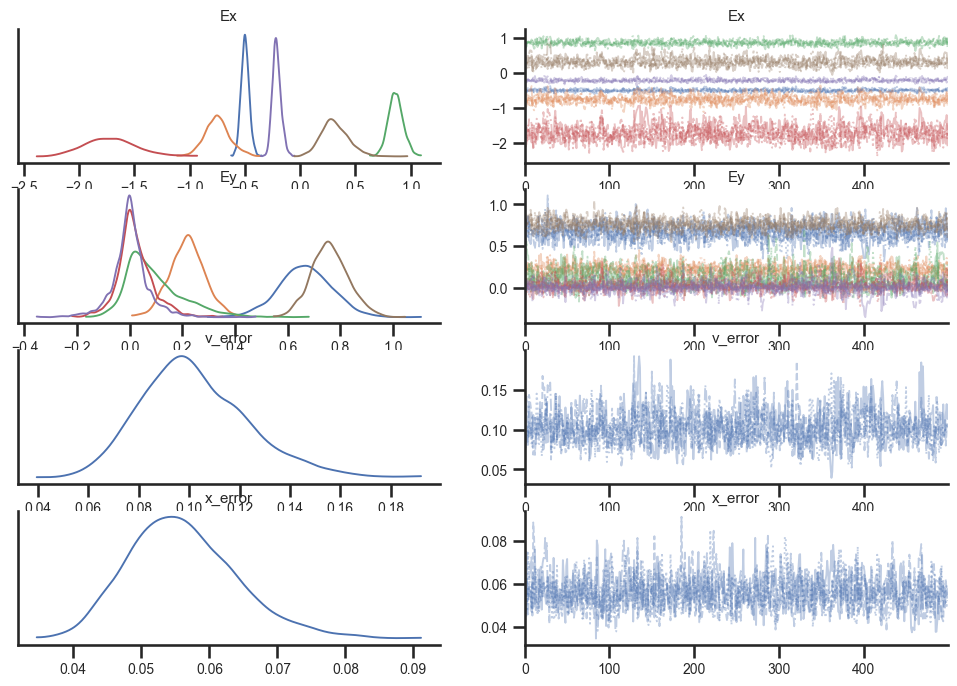

In [19]:
tp = pm.plot_trace(trace, var_names=['Ex', 'Ey', 'v_error', 'x_error'], combined=True,
                  lines={'Ex': ex_wu.T.flatten(), 'Ey': ey_wu.T.flatten()})
sns.despine()

for ax in tp.flatten():
    ax.set_rasterized(True)

# plt.savefig('wu_trace.svg', dpi=100, transparent=True)

In [20]:
ex = trace.posterior['Ex'].to_numpy().reshape((2000, -1))
ey = trace.posterior['Ey'].to_numpy().reshape((2000, -1))
e_all = np.hstack([ex, ey])

In [21]:
m_labels = [m.id for m in model.metabolites]
r_labels = [r.id for r in model.reactions]
y_labels = ['BPG', 'ADP']

ex_labels = np.array([['$\epsilon_{' + '{0},{1}'.format(rlabel, mlabel) + '}$'
                       for mlabel in m_labels] for rlabel in r_labels]).flatten()
ey_labels = np.array([['$\epsilon_{' + '{0},{1}'.format(rlabel, mlabel) + '}$'
                       for mlabel in y_labels] for rlabel in r_labels]).flatten()

e_labels = np.hstack((ex_labels, ey_labels))

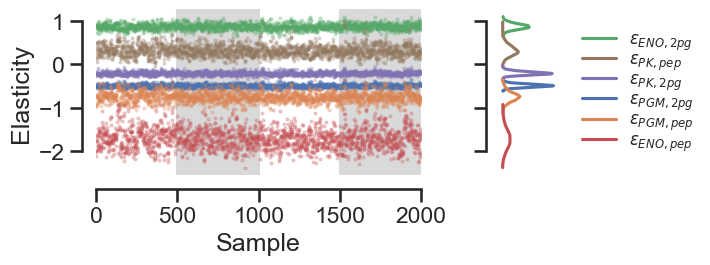

In [22]:
fig = plt.figure(figsize=(6,3))

ax = plt.subplot2grid((1, 4), (0, 0), colspan=3)

ax.plot(ex, '.', ms=4, alpha=.25, rasterized=True)
ax.axvspan(500, 1000, zorder=0, color='.85')
ax.axvspan(1500, 2000, zorder=0, color='.85')
ax.set_xlim([0, 2000])


sns.despine(trim=True, offset=10, ax=ax)
ax.set_ylabel('Elasticity')
ax.set_xlabel('Sample')

ax2 = plt.subplot2grid((1, 4), (0, 3), colspan=1, fig=fig, sharey=ax)
ax2.xaxis.set_visible(False)
sns.despine(trim=True, offset=10, ax=ax2, bottom=True)

colors = sns.color_palette()
for i in ex.mean(0).argsort()[::-1]:
    x, y = pm.kde(ex[:, i])
    ax2.plot(y, x, label=e_labels[i], color=colors[i])

plt.setp(ax2.get_yticklabels(), visible=False)
plt.tight_layout()
    
ax2.legend(loc='center left', fontsize=12, bbox_to_anchor=(1.2, .5), labelspacing=0)
    
# plt.savefig('wu_trace_subset.svg', dpi=200)

In [23]:
pm.hdi(trace.posterior['ey_kinetic_entries'])

<xarray.Dataset>
Dimensions:                   (ey_kinetic_entries_dim_0: 2, hdi: 2)
Coordinates:
  * ey_kinetic_entries_dim_0  (ey_kinetic_entries_dim_0) int64 0 1
  * hdi                       (hdi) <U6 'lower' 'higher'
Data variables:
    ey_kinetic_entries        (ey_kinetic_entries_dim_0, hdi) float64 0.4723 ...

In [24]:
pm.hdi(trace.posterior['ey_capacity_entries'])

<xarray.Dataset>
Dimensions:                    (ey_capacity_entries_dim_0: 4, hdi: 2)
Coordinates:
  * ey_capacity_entries_dim_0  (ey_capacity_entries_dim_0) int64 0 1 2 3
  * hdi                        (hdi) <U6 'lower' 'higher'
Data variables:
    ey_capacity_entries        (ey_capacity_entries_dim_0, hdi) float64 0.097...

In [25]:
# e_df = pd.DataFrame(e_all, columns=e_labels)
# e_df.apply(pm.hdi)

(0.1, 11.9)

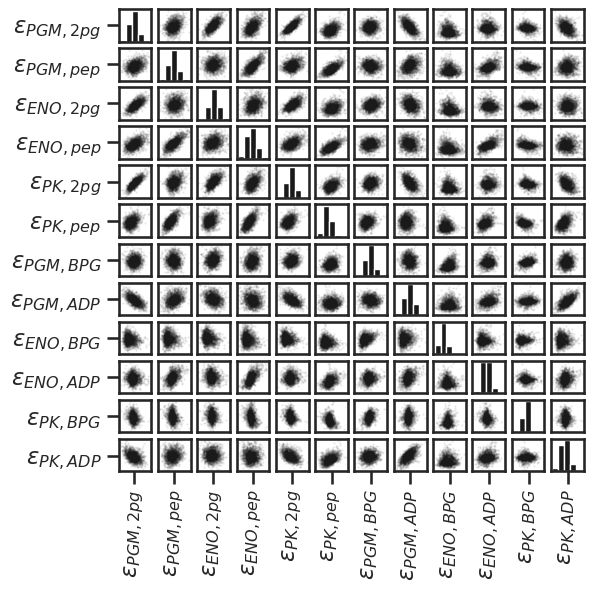

In [26]:
fig, axmatrix = plt.subplots(nrows=12, ncols=12, figsize=(6, 6))

for ax in axmatrix.flatten():
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

for i in range(12):
    for j in range(12):
        if i is not j:
            axmatrix[i,j].plot(e_all[:, i], e_all[:, j],
                               'k.', alpha=0.1, ms=1, rasterized=True)
        else:
            axmatrix[i,j].hist(e_all[:, i], bins=5, color='k', edgecolor='w', lw=1)
            
_ = ax_all = fig.add_subplot(111, frameon=False)
_ = ax_all.set_xticks(np.arange(12) + 0.5)
_ = ax_all.set_xticklabels(e_labels, rotation=90)
_ = ax_all.set_yticks(np.arange(12) + 0.5)
_ = ax_all.set_yticklabels(e_labels[::-1])

ax_all.set_xlim([0.1, 11.9])
ax_all.set_ylim([0.1, 11.9])

# fig.savefig('elasticity_pairplot.svg', dpi=400, transparent=True)

In [27]:
with pymc_model:
    ppc = pm.sample_posterior_predictive(trace)

Sampling: [chi_obs, v_hat_obs]


## Equivalent approach using variational inference

Here we approximate the posterior distribution using ADVI to compare the two methods.

In [28]:
with pymc_model:
    approx = pm.ADVI()
    hist = approx.fit(n=25000, obj_optimizer=pm.adagrad_window(learning_rate=5E-3),
                      obj_n_mc=1)
    
with pymc_model:
    trace_vi = hist.sample(1000)
    ppc_vi = pm.sample_posterior_predictive(trace_vi)

Finished [100%]: Average Loss = -25.087
Sampling: [chi_obs, v_hat_obs]


ADVI is an optimization-based method, so we monitor the evidence lower bound to check convergence

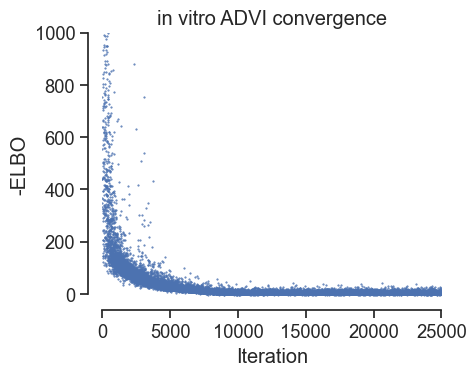

In [29]:
with sns.plotting_context('notebook', font_scale=1.2):

    fig = plt.figure(figsize=(5,4))
    plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
    plt.ylim([-1E1, 1E3])
    plt.xlim([0, 25000])
    sns.despine(trim=True, offset=10)

    plt.ylabel('-ELBO')
    plt.xlabel('Iteration')
    plt.title('in vitro ADVI convergence')
    plt.tight_layout()
    # plt.savefig('wu_elbo.svg', transparent=True, dpi=200)

In [30]:
x = giersch.loc[:, ['2PG', 'PEP']]

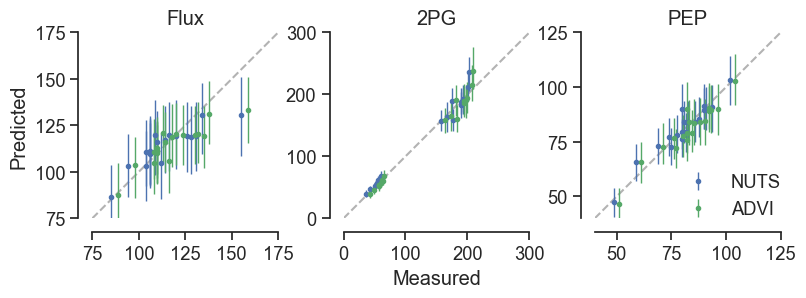

In [31]:
with sns.plotting_context('notebook', font_scale=1.2):

    fig, axmatrix = plt.subplots(ncols=3, figsize=(8,3.5))

    for ax in axmatrix.flatten():
        ax.set_aspect('equal')

    def plot_hpd_err(truth, ppc, ax, color=None):
        median = ppc.median(dim=['chain','draw'])
        hpd = pm.hdi(ppc)
        err = np.abs(hpd - median).to_array()[0]#median[:, np.newaxis])

        return ax.errorbar(truth, median, yerr=err.T, ls='',
                           marker='.', elinewidth=1., color=color)

    plot_hpd_err(vn * v_star[0] - 2, ppc.posterior_predictive['v_hat_obs'] * v_star[0], axmatrix[0])
    plot_hpd_err(x['2PG'].values - 3, x_star[0] * np.exp(ppc.posterior_predictive['chi_obs'][:,:,:,0]),
                 axmatrix[1])
    l0 = plot_hpd_err(x['PEP'].values - 1.25, x_star[1] * np.exp(ppc.posterior_predictive['chi_obs'][:,:,:,1]),
                      axmatrix[2])

    plot_hpd_err(vn * v_star[0] + 2, ppc_vi.posterior_predictive['v_hat_obs'] * v_star[0], axmatrix[0], 'g')
    plot_hpd_err(x['2PG'].values + 3, x_star[0] * np.exp(ppc_vi.posterior_predictive['chi_obs'][:,:,:,0]),
                 axmatrix[1], 'g')
    l1 = plot_hpd_err(x['PEP'].values + 1.25, x_star[1] * np.exp(ppc_vi.posterior_predictive['chi_obs'][:,:,:,1]),
                      axmatrix[2], 'g')

    axmatrix[0].set_title('Flux')
    axmatrix[1].set_title('2PG')
    axmatrix[2].set_title('PEP')
    # axmatrix[3].set_title('Enzymes')

    axmatrix[1].set_xlabel('Measured')
    axmatrix[0].set_ylabel('Predicted')

    fig.tight_layout()

    ax0 = [75, 175]
    ax2 = [40, 125]
    
    axmatrix[0].set_xlim(*ax0)
    axmatrix[0].set_ylim(ax0)
    axmatrix[0].plot(ax0, ax0, '--', color='.7', zorder=0)

    axmatrix[1].set_xlim([0, 300])
    axmatrix[1].set_ylim([0, 300])
    axmatrix[1].plot([0, 300], [0, 300], '--', color='.7', zorder=0)

    axmatrix[2].set_xlim(*ax2)
    axmatrix[2].set_ylim(*ax2)
    axmatrix[2].plot(ax2, ax2, '--', color='.7', zorder=0)

    # axmatrix[3].plot([0, 60], [0, 60], '--', color='.7', zorder=0)

    axmatrix[0].set_yticks(np.arange(75, 200, 25))
    axmatrix[0].set_xticks(np.arange(75, 200, 25))

    axmatrix[1].set_yticks(np.arange(0, 350, 100))
    axmatrix[1].set_xticks(np.arange(0, 350, 100))

    axmatrix[2].set_yticks(np.arange(50, 150, 25))
    axmatrix[2].set_xticks(np.arange(50, 150, 25))

    leg = plt.legend([l0, l1], ['NUTS', 'ADVI'],
                     loc='lower right', borderpad=0, borderaxespad=0)

    sns.despine(trim=False, offset=10)
    # fig.savefig('ppc_predictions.svg')

In [32]:
ex = trace.posterior['Ex'].to_numpy().reshape((2000, -1))
ey = trace.posterior['Ey'].to_numpy().reshape((2000, -1))
e_all = np.hstack([ex, ey])

In [33]:
e_df = pd.DataFrame(e_all, columns=e_labels)

# Create an empty DataFrame to store HDI results in wide format
hdi_results = pd.DataFrame(columns=e_df.columns)

# Iterate through each column and calculate HDI separately
for column in e_df.columns:
    hdi = pm.hdi(e_df[column].values)
    hdi_results[column] = hdi

# Display or use the DataFrame with HDI results in wide format
hdi_results

e_df = hdi_results
e_df

,"$\epsilon_{PGM,2pg}$","$\epsilon_{PGM,pep}$","$\epsilon_{ENO,2pg}$","$\epsilon_{ENO,pep}$","$\epsilon_{PK,2pg}$","$\epsilon_{PK,pep}$","$\epsilon_{PGM,BPG}$","$\epsilon_{PGM,ADP}$","$\epsilon_{ENO,BPG}$","$\epsilon_{ENO,ADP}$","$\epsilon_{PK,BPG}$","$\epsilon_{PK,ADP}$"
0,-0.565769,-0.966839,0.748056,-2.143378,-0.281024,0.089217,0.472263,0.097616,-0.086974,-0.092187,-0.128748,0.628726
1,-0.426731,-0.521207,1.004549,-1.267993,-0.135457,0.550557,0.847838,0.351618,0.301558,0.176812,0.146493,0.895259


Here we calculate the flux control coefficients for both the ADVI and NUTS posteriors

In [34]:
fcc = np.array([ll.flux_control_coefficient(Ex=ex) for ex in trace.posterior['Ex'][0].to_numpy()])
fcc_mb = np.array([ll.flux_control_coefficient(Ex=ex) for ex in trace_vi.posterior['Ex'][0].to_numpy()])
fcc_prior = np.array([ll.flux_control_coefficient(Ex=ex) for ex in trace_prior.prior['Ex'][0].to_numpy()])

In [35]:
# Control coefficients estimated from elasticities
# Wu table 7

wu_ccs = np.array([-0.34 , 0.14 , 1.20])

In [36]:
df1 = pd.DataFrame(fcc[:, 0], columns=[r.id for r in model.reactions]
                  ).stack().reset_index(level=1)
df2 = pd.DataFrame(fcc_mb[:, 0], columns=[r.id for r in model.reactions]
                  ).stack().reset_index(level=1)
df3 = pd.DataFrame(fcc_prior[:, 0], columns=[r.id for r in model.reactions]
                  ).stack().reset_index(level=1)

df1['type'] = 'NUTS'
df2['type'] = 'ADVI'
df3['type'] = 'Prior'


fcc_df = pd.concat([df1, df2, df3])
fcc_df.columns = ['Reaction', 'FCC', 'Type']

fcc_df.loc[fcc_df.FCC < -.5, 'FCC'] = np.nan
fcc_df.loc[fcc_df.FCC > 1.5, 'FCC'] = np.nan

In [37]:
ax.patches

<Axes.ArtistList of 0 patches>

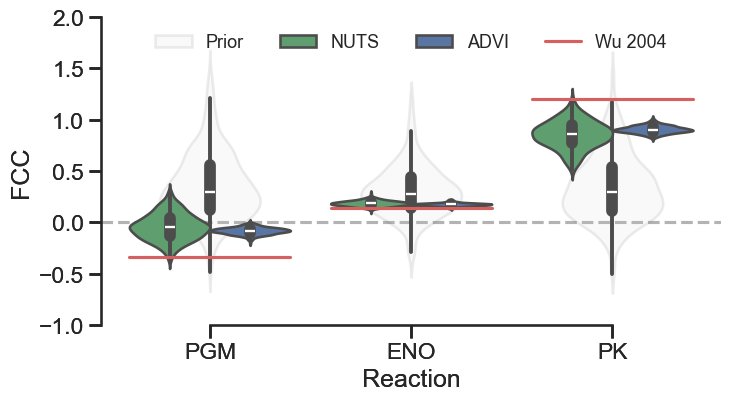

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reset index to avoid duplicate labels
fcc_df_reset = fcc_df.reset_index()

# Create a figure and axes
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax2 = fig.add_subplot(111, frameon=False, sharex=ax, sharey=ax)

# Define palette colors for different types
my_pal = {"Prior": ".8", "NUTS": "g", "ADVI": "b"}

# Filter data for specific type 'Prior'
data_prior = fcc_df_reset[fcc_df_reset.Type == 'Prior']

# Create violin plot for 'Prior' type on ax
sns.violinplot(
    x='Reaction', y='FCC', hue='Type', data=data_prior,
    density_norm='width', width=0.5, palette=my_pal, saturation=1., alpha=0.1, ax=ax
)

# Create violin plot for all types ('NUTS' and 'ADVI') on ax2 (twin axes)
sns.violinplot(
    x='Reaction', y='FCC', hue='Type', data=fcc_df_reset,
    density_norm='width', width=0.8, hue_order=['NUTS', 'ADVI'],
    palette=my_pal, ax=ax2
)

# Additional plot elements or customizations
for i, cc in enumerate(wu_ccs):
    ax2.plot([i - .4, i + .4], [cc, cc], '-', color=sns.color_palette('muted')[3])

# Get legend handles and labels for both axes
phandles, plabels = ax.get_legend_handles_labels()
handles, labels = ax2.get_legend_handles_labels()

# Remove individual legends
ax.legend().remove()
ax2.legend().remove()

# Combine legends for both axes and Wu 2004 into a single legend
legend = ax2.legend(phandles + handles + [plt.Line2D([0], [0], color=sns.color_palette('muted')[3])],
            plabels + labels + ['Wu 2004'], loc='upper center', ncol=4, fontsize=13)

# Set y-axis limit for ax
ax.set_ylim([-1, 2])

# Add horizontal line at y=0 to ax
ax.axhline(0, ls='--', color='.7', zorder=0)

# Remove spines for aesthetics
sns.despine(trim=True)
# Save the figure
#fig.savefig('wu_fccs.svg', transparent=True)


In [39]:
ex_vi = trace_vi.posterior['Ex'].to_numpy().reshape((len(trace_vi.posterior['Ex'][0]), -1))
ey_vi = trace_vi.posterior['Ey'].to_numpy().reshape((len(trace_vi.posterior['Ey'][0]), -1))
e_all_vi = np.hstack([ex_vi, ey_vi])

e_df_vi = pd.DataFrame(e_all_vi, columns=e_labels)

# Create an empty DataFrame to store HDI results in wide format
hdi_results = pd.DataFrame(columns=e_df_vi.columns)

# Iterate through each column and calculate HDI separately
for column in e_df_vi.columns:
    hdi = pm.hdi(e_df_vi[column].values)
    hdi_results[column] = hdi

# Display or use the DataFrame with HDI results in wide format
e_df_vi = hdi_results
e_df_vi

,"$\epsilon_{PGM,2pg}$","$\epsilon_{PGM,pep}$","$\epsilon_{ENO,2pg}$","$\epsilon_{ENO,pep}$","$\epsilon_{PK,2pg}$","$\epsilon_{PK,pep}$","$\epsilon_{PGM,BPG}$","$\epsilon_{PGM,ADP}$","$\epsilon_{ENO,BPG}$","$\epsilon_{ENO,ADP}$","$\epsilon_{PK,BPG}$","$\epsilon_{PK,ADP}$"
0,-0.521636,-0.842570,0.795357,-1.938392,-0.247585,0.189527,0.491519,0.180916,-0.109114,-0.061945,-0.080500,0.713496
1,-0.467871,-0.696959,0.935365,-1.594867,-0.178840,0.356936,0.783479,0.255711,0.190721,0.067823,0.092868,0.816520


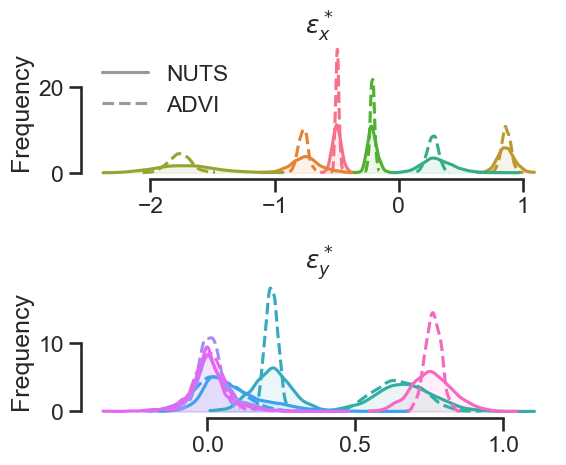

In [40]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have the data arrays ex, ex_vi, ey, ey_vi
# Modify as needed based on your data setup

colors = sns.color_palette('husl', n_colors=12)  # Assuming a total of 12 colors needed

fig, axmatrix = plt.subplots(nrows=2, sharex=False, figsize=(6, 5))

for i, color in enumerate(colors[:6]):
    az.plot_kde(np.array(ex[:, i]), plot_kwargs={'color': color}, fill_kwargs={'color': color, 'alpha': 0.1}, ax=axmatrix[0])
    az.plot_kde(np.array(ex_vi[:, i]), plot_kwargs={'color': color}, ax=axmatrix[0])
    lines = axmatrix[0].get_lines()  # Get the lines from the plot
    lines[-1].set_linestyle('--')  # Set linestyle for the last line

for i, color in enumerate(colors[6:]):
    az.plot_kde(np.array(ey[:, i]), plot_kwargs={'color': color}, fill_kwargs={'color': color, 'alpha': 0.1}, ax=axmatrix[1])
    az.plot_kde(np.array(ey_vi[:, i]), plot_kwargs={'color': color}, ax=axmatrix[1])
    lines = axmatrix[1].get_lines()  # Get the lines from the plot
    lines[-1].set_linestyle('--')  # Set linestyle for the last line

hmc_line = plt.Line2D([], [], color='.6', ls='-', label='NUTS')  # Create Line2D for legend
vi_line = plt.Line2D([], [], color='.6', ls='--', label='ADVI')  # Create Line2D for legend

axmatrix[0].set_ylabel('Frequency')
axmatrix[1].set_ylabel('Frequency')

axmatrix[0].set_title('$\epsilon_x^*$')
axmatrix[1].set_title('$\epsilon_y^*$')

axmatrix[0].legend(handles=[hmc_line, vi_line], loc='upper left')
plt.tight_layout()
sns.despine(trim=True)
plt.show()  # Display the plot
# fig.savefig('advi_nuts_elasticity.svg', transparent=True)


## Save results to file for testing/comparison

In [78]:
[str(int(i+1)) for i in np.arange(len(priors_df.index)/3)]

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '13

In [90]:
# Save FCC prior predictives
display(df3)
priors_df = df3.copy()
priors_df['FCC_ref'] = [x for x in priors_df.index]
priors_df = priors_df.rename(columns={'level_1': 'Reaction', 0: 'FCC'}).reset_index()
priors_df = priors_df.pivot(index='Reaction', values='FCC', columns='FCC_ref')

display(priors_df)
priors_df.to_csv('../tests/test_data/expected_wu2004_FCCpriors.csv')

,level_1,0,type
0,PGM,0.084288,Prior
0,ENO,0.816874,Prior
0,PK,0.098838,Prior
1,PGM,0.310687,Prior
1,ENO,0.173424,Prior
...,...,...,...
498,ENO,0.339782,Prior
498,PK,0.876267,Prior
499,PGM,1.124280,Prior
499,ENO,-0.160071,Prior


FCC_ref,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Reaction,,,,,,,,,,,,,,,,,,,,,
ENO,0.816874,0.173424,0.011988,0.585287,0.323544,0.052289,0.348569,0.480646,0.140567,0.278206,...,0.579299,0.242190,0.470005,0.000075,0.133819,0.112403,0.292782,0.491306,0.339782,-0.160071
PGM,0.084288,0.310687,0.021441,0.206144,0.370449,-0.083065,0.585779,0.466715,0.028405,0.382373,...,0.195198,0.703626,0.453408,0.953604,0.620637,0.272431,0.761661,0.216657,-0.216049,1.124280
PK,0.098838,0.515888,0.966571,0.208570,0.306007,1.030776,0.065652,0.052639,0.831028,0.339420,...,0.225503,0.054185,0.076588,0.046321,0.245544,0.615165,-0.054443,0.292037,0.876267,0.035792


<Axes: xlabel='Reaction', ylabel='FCC'>

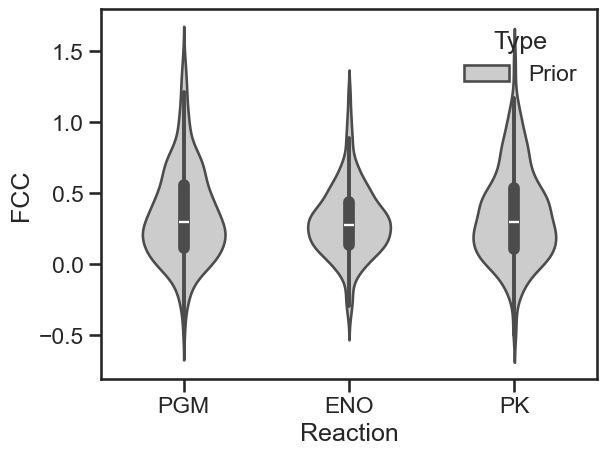

In [46]:
# Create violin plot for 'Prior' type on ax
sns.violinplot(
    x='Reaction', y='FCC', hue='Type', data=data_prior,
    density_norm='width', width=0.5, palette=my_pal, saturation=1.
)

In [49]:
# Save FCC posterior predictives
display(df1)
df1.to_csv('../tests/test_data/expected_wu2004_FCC_posterior_NUTS.csv')
display(df2)
df2.to_csv('../tests/test_data/expected_wu2004_FCC_posterior_ADVI.csv')

,level_1,0,type
0,PGM,-0.171714,NUTS
0,ENO,0.166104,NUTS
0,PK,1.005611,NUTS
1,PGM,-0.184127,NUTS
1,ENO,0.212176,NUTS
...,...,...,...
498,ENO,0.209799,NUTS
498,PK,0.611608,NUTS
499,PGM,0.080888,NUTS
499,ENO,0.121807,NUTS


,level_1,0,type
0,PGM,-0.100514,ADVI
0,ENO,0.163578,ADVI
0,PK,0.936936,ADVI
1,PGM,-0.071819,ADVI
1,ENO,0.183474,ADVI
...,...,...,...
998,ENO,0.175839,ADVI
998,PK,0.929507,ADVI
999,PGM,-0.066807,ADVI
999,ENO,0.191240,ADVI


In [51]:
display(ppc.posterior_predictive['chi_obs'])
display(ppc.posterior_predictive['v_hat_obs'])

<xarray.DataArray 'chi_obs' (chain: 4, draw: 500, chi_obs_dim_2: 19,
                             chi_obs_dim_3: 2)>
array([[[[ 1.08420613e+00, -8.07719287e-01],
         [ 7.35360805e-02, -3.06056760e-02],
         [-1.18030661e-01, -1.37121157e-01],
         ...,
         [ 1.11215661e+00, -1.26434397e-01],
         [ 1.15180463e+00, -2.72844106e-01],
         [ 1.18923111e+00, -3.49354518e-01]],

        [[ 1.04999001e+00, -6.57435729e-01],
         [ 1.36917320e-02, -6.22320543e-03],
         [-1.13213430e-01, -1.04112815e-01],
         ...,
         [ 1.08567625e+00, -1.59886166e-01],
         [ 1.13859952e+00, -1.93933010e-01],
         [ 1.20127199e+00, -2.71993922e-01]],

        [[ 1.06515806e+00, -7.54618115e-01],
         [ 2.70038056e-02, -9.18481254e-02],
         [ 9.35520715e-02, -1.16780075e-01],
         ...,
...
         ...,
         [ 1.14988002e+00, -4.24038671e-02],
         [ 1.21429250e+00, -1.10204684e-01],
         [ 1.19243406e+00, -2.15155971e-01]],

        [[ 9.91807437e-01, -8.41521484e-01],
         [-9.92430560e-02, -1.67719436e-03],
         [-1.11928581e-01, -1.15755575e-01],
         ...,
         [ 1.13773320e+00, -1.31338060e-01],
         [ 1.02025489e+00, -1.77837753e-01],
         [ 1.22301211e+00, -1.82545837e-01]],

        [[ 1.11181026e+00, -7.60978129e-01],
         [-8.58045566e-02, -1.25540070e-02],
         [-9.35895517e-02, -1.61416335e-02],
         ...,
         [ 1.26514783e+00, -1.18158503e-01],
         [ 1.14207715e+00, -2.40341760e-01],
         [ 1.21979536e+00, -3.57870158e-01]]]])
Coordinates:
  * chain          (chain) int64 0 1 2 3
  * draw           (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * chi_obs_dim_2  (chi_obs_dim_2) int64 0 1 2 3 4 5 6 ... 12 13 14 15 16 17 18
  * chi_obs_dim_3  (chi_obs_dim_3) int64 0 1

<xarray.DataArray 'v_hat_obs' (chain: 4, draw: 500, v_hat_obs_dim_2: 19)>
array([[[1.69768278, 0.99376089, 1.2767478 , ..., 0.90188943,
         1.28227255, 1.22493165],
        [1.56799328, 1.04490174, 1.14768703, ..., 1.29021779,
         1.22944455, 1.20851924],
        [1.6977591 , 1.07290336, 1.24404556, ..., 0.918095  ,
         1.49787697, 1.32933201],
        ...,
        [1.36251961, 0.80201166, 0.9486992 , ..., 1.07376563,
         1.27770902, 1.23402146],
        [1.46067967, 0.90192143, 1.15464488, ..., 1.15441905,
         1.50493512, 1.4396041 ],
        [1.47167905, 0.80745768, 1.34008044, ..., 1.4784615 ,
         1.4113527 , 1.35524938]],

       [[1.41905101, 1.09542224, 1.34703896, ..., 1.03687519,
         1.46838517, 1.21498952],
        [1.59239476, 1.00622513, 1.26755882, ..., 1.14073426,
         1.05404483, 1.36100385],
        [1.54710579, 1.05015655, 1.05812809, ..., 1.30528503,
         1.26563775, 1.33613206],
...
        [1.49326145, 1.12234262, 1.17799427, ..., 1.2539081 ,
         1.26372935, 1.37668773],
        [1.11964101, 0.79194359, 1.14036018, ..., 1.20448184,
         1.18114027, 1.27345658],
        [1.55098782, 0.96075463, 1.20857819, ..., 1.0708805 ,
         1.2356893 , 1.31167358]],

       [[1.36370587, 1.04765251, 1.08297795, ..., 1.13041075,
         1.16425415, 1.22968432],
        [1.55915904, 0.97840826, 1.29375005, ..., 1.17316644,
         1.24272337, 1.48634125],
        [1.47903775, 0.95449468, 1.04704289, ..., 1.20328266,
         1.20125987, 1.30738218],
        ...,
        [1.58234085, 1.10543187, 1.27663654, ..., 1.00098612,
         1.23591532, 1.36478136],
        [1.55378756, 0.96667523, 1.08794305, ..., 1.39327833,
         1.34070785, 1.39817524],
        [1.56707797, 1.10963923, 1.04984453, ..., 1.22311131,
         1.23017492, 1.49471898]]])
Coordinates:
  * chain            (chain) int64 0 1 2 3
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499
  * v_hat_obs_dim_2  (v_hat_obs_dim_2) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18

In [ ]:
# metabolite concentrations


# enzyme concentrations


# flux rates


In [ ]:
def plot_hpd_err(truth, ppc, ax, color=None):
        median = ppc.median(dim=['chain','draw'])
        hpd = pm.hdi(ppc)
        err = np.abs(hpd - median).to_array()[0]#median[:, np.newaxis])

        return ax.errorbar(truth, median, yerr=err.T, ls='',
                           marker='.', elinewidth=1., color=color)

plot_hpd_err(vn * v_star[0] - 2, ppc.posterior_predictive['v_hat_obs'] * v_star[0], axmatrix[0])
plot_hpd_err(x['2PG'].values - 3, x_star[0] * np.exp(ppc.posterior_predictive['chi_obs'][:,:,:,0]),
                axmatrix[1])
l0 = plot_hpd_err(x['PEP'].values - 1.25, x_star[1] * np.exp(ppc.posterior_predictive['chi_obs'][:,:,:,1]),
                axmatrix[2])

plot_hpd_err(vn * v_star[0] + 2, ppc_vi.posterior_predictive['v_hat_obs'] * v_star[0], axmatrix[0], 'g')
plot_hpd_err(x['2PG'].values + 3, x_star[0] * np.exp(ppc_vi.posterior_predictive['chi_obs'][:,:,:,0]),
                axmatrix[1], 'g')
l1 = plot_hpd_err(x['PEP'].values + 1.25, x_star[1] * np.exp(ppc_vi.posterior_predictive['chi_obs'][:,:,:,1]),
                axmatrix[2], 'g')